In [1]:
data = read.csv('hw9t4v1.txt',sep = '',header = FALSE)

In [2]:
head(data)

V1,V2,V3,V4,V5,V6,V7
0.001,8.613,0.141,1.951,2.228,1.899,53.920
0.000,10.891,0.148,3.108,1.039,1.919,66.760
0.000,12.367,0.180,2.129,2.790,1.254,81.493
0.000,1.426,0.148,3.330,1.625,1.988,33.369
0.000,3.523,0.227,2.930,1.176,0.027,40.666
0.000,12.645,0.148,2.108,1.159,1.937,66.223


In [3]:
n<-400
q<-100

In [4]:
## 75% of the sample size
smp_size <- floor(n)

## set the seed to make your partition reproductible
train_ind <- 1:n

train <- data[train_ind, ]
test <- data[-train_ind, ]

In [5]:
library("ggplot2") # графики
library("sandwich") # оценка Var для гетероскедастичности
library("lmtest") # тест Бройша-Пагана
library("dplyr") # манипуляции с данными

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [7]:
head(train)

V1,V2,V3,V4,V5,V6,V7
0.001,8.613,0.141,1.951,2.228,1.899,53.920
0.000,10.891,0.148,3.108,1.039,1.919,66.760
0.000,12.367,0.180,2.129,2.790,1.254,81.493
0.000,1.426,0.148,3.330,1.625,1.988,33.369
0.000,3.523,0.227,2.930,1.176,0.027,40.666
0.000,12.645,0.148,2.108,1.159,1.937,66.223


проверим модель на гомоскедастичность

In [9]:
model<-lm(V7 ~ V1 + V2 + V3 + V4 + V5 + V6, data=train)

In [10]:
summary(model)


Call:
lm(formula = V7 ~ V1 + V2 + V3 + V4 + V5 + V6, data = train)

Residuals:
   Min     1Q Median     3Q    Max 
-9.979 -4.758 -1.537  3.002 24.514 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 32.33087    2.25187  14.357   <2e-16 ***
V1           3.44853    3.63407   0.949   0.3432    
V2           2.87628    0.07244  39.706   <2e-16 ***
V3           2.83741    9.11249   0.311   0.7557    
V4          -0.21417    0.35257  -0.607   0.5439    
V5          -0.79329    0.41126  -1.929   0.0545 .  
V6           1.38325    0.73778   1.875   0.0615 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.618 on 393 degrees of freedom
Multiple R-squared:  0.8014,	Adjusted R-squared:  0.7984 
F-statistic: 264.3 on 6 and 393 DF,  p-value: < 2.2e-16


тесты на гетероскедастичность:

In [24]:
pvals <- c(bptest(model)$p.value,
            bptest(model, studentize = FALSE)$p.value,
            gqtest(model, fraction = 0.2)$p.value)
corrected_pvals <- p.adjust(pvals, method = 'holm')

In [28]:
corrected_pvals < 0.05

BP    BP       
FALSE FALSE FALSE

как видно, гомоскедастичность не отвергается, к тому же не было теоритических оснований пологать о наличии гетероскедастичности + данных достаточно много, поэтому будем использовать обычные методы.

Возможная мультиколлинеарность никого не волнует

In [38]:
library(car)

In [29]:
summary(model)


Call:
lm(formula = V7 ~ V1 + V2 + V3 + V4 + V5 + V6, data = train)

Residuals:
   Min     1Q Median     3Q    Max 
-9.979 -4.758 -1.537  3.002 24.514 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 32.33087    2.25187  14.357   <2e-16 ***
V1           3.44853    3.63407   0.949   0.3432    
V2           2.87628    0.07244  39.706   <2e-16 ***
V3           2.83741    9.11249   0.311   0.7557    
V4          -0.21417    0.35257  -0.607   0.5439    
V5          -0.79329    0.41126  -1.929   0.0545 .  
V6           1.38325    0.73778   1.875   0.0615 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.618 on 393 degrees of freedom
Multiple R-squared:  0.8014,	Adjusted R-squared:  0.7984 
F-statistic: 264.3 on 6 and 393 DF,  p-value: < 2.2e-16


видно, что все признаки кроме V2 незначимы, поэтому нужно воспользоваться каким нибудь алгоритмом, который оставит оптимальное число значимых признаков.
Возьмем алгоритм из задачи 8.6 и наберем признаки жадно, используя как критерий информативности aic (штрафует меньше чем bic, поэтому алгоритм может набрать несколько незначимых столбцов).

In [52]:
add_next<-function(used, X, f, data, best='None') {
    all = colnames(X)
    best_name = ''
    update = FALSE
    Y = data$V7
    for(name in setdiff(all, used)) {
        used_new = c(used,name)
        new_X = as.matrix(data[,used_new])
        fit<-lm(Y ~ new_X)
        pred<-as.numeric(predict(fit,data[7]))
        cur<-f(new_X, Y, pred)
        if(best == 'None' || cur < best) {
            best = cur
            best_name = name
            update = TRUE
        }
    }
      
    if(update) {
        print('update:')
        print(best_name)
        return(c(best_name, best, used))
    }
    
    print('No Update')
    return(c())
}

aic<-function(X,real, pred) {
    k = ncol(X)
    n = nrow(X)
    rss = dist(rbind(pred,real))^2
    return(2 * k/n + (log(rss / n) + 1))
}

calc_model<-function(f,data) {
    used = c()
    History = c()
    best = 'None'
    while(TRUE) {
        cache = add_next(used,data[-c(7)],f,data,best)
        if (length(cache) == 0) {
            break
        } else {
            History = c(History, cache[2])
            used = c(used, cache[1])
            best = cache[2]
        }
    }
    return (c(History, used))
}

In [53]:
res = calc_model(aic, train)

[1] "update:"
[1] "V2"
[1] "update:"
[1] "V5"
[1] "update:"
[1] "V6"
[1] "No Update"


алгоритм оставил только значимый признак V2 как и ожидалось + 2 незначимых признака V5 и V6

In [54]:
model<-lm(V7 ~ V2 + V5 + V6, data=train)
pred<-as.numeric(predict(model, test))

In [55]:
summary(model)


Call:
lm(formula = V7 ~ V2 + V5 + V6, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.613  -4.837  -1.643   3.112  24.431 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 32.31201    1.48067  21.822   <2e-16 ***
V2           2.86934    0.07202  39.840   <2e-16 ***
V5          -0.80301    0.40971  -1.960   0.0507 .  
V6           1.38880    0.73449   1.891   0.0594 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.604 on 396 degrees of freedom
Multiple R-squared:  0.8007,	Adjusted R-squared:  0.7992 
F-statistic: 530.4 on 3 and 396 DF,  p-value: < 2.2e-16


статистики для V5 и V6 на границе значимости 0.05

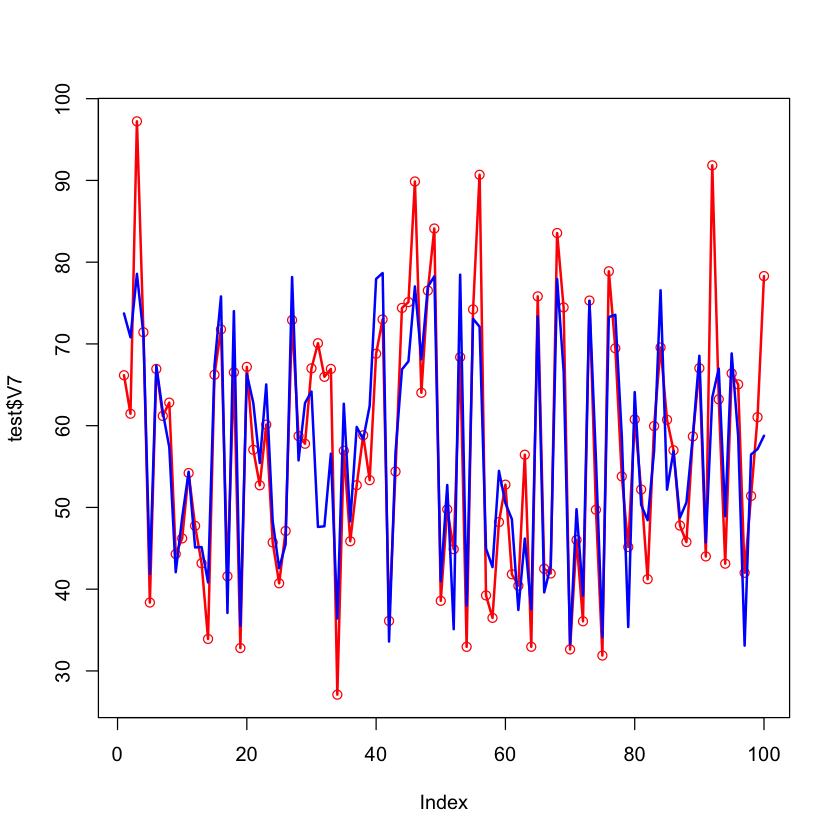

In [56]:
plot(test$V7,col = 'red')
lines(test$V7, col = "red", lwd = 2)
lines(pred, col = "blue", lwd = 2)

In [57]:
mean(abs(pred - test$V7)/((abs(pred) + abs(test$V7))/2))

[1] 0.09606778

smape получился очень хорошим